### **AutoEncoder Inference**

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Reshape, Conv2DTranspose, Cropping2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler, TensorBoard
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception, MobileNetV2
from tensorflow.python.keras import regularizers

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

1/1 [==============================] - 3s 3s/step
#######재구성 손실 (MSE)########: 0.00092263607


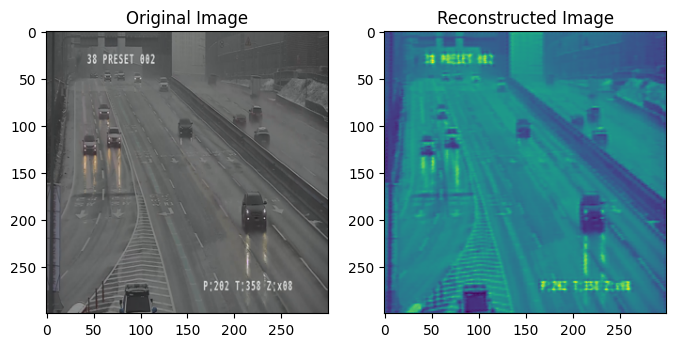

In [ ]:
# 모델 로드 (SavedModel 디렉터리 경로를 지정하세요)
autoencoder = tf.keras.models.load_model('/content/drive/Othercomputers/내 노트북/google_drive/convolutional_autoencoder_result')

# 단일 이미지 로드
image_path = "/content/drive/Othercomputers/내 노트북/google_drive/object_detection_inference/Suwon_CH02_20201213_0933_SUN_9m_NH_highway_TW5_snow_FHD_003.png"
image = Image.open(image_path)

# 모델의 입력 크기로 이미지 리사이즈 (예: 300x300)
target_size = (300, 300)
image = image.resize(target_size)

image = image.convert("RGB")  # 채널 수 맞추기 (필요시)

# 이미지를 NumPy 배열로 변환 및 전처리
single_image = np.array(image).astype('float32') / 255.0
single_image = np.expand_dims(single_image, axis=0)

# 재구성된 이미지 얻기
reconstructed_image = autoencoder.predict(single_image)

# 재구성 손실 계산
mse = MeanSquaredError()
reconstruction_loss = mse(single_image, reconstructed_image).numpy()
print("#######재구성 손실 (MSE)########:", reconstruction_loss)

# 원본 이미지와 재구성된 이미지 시각화
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(single_image.squeeze())
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image.squeeze())
plt.show()

In [ ]:
# 아래에서 세션 다시 시작시 reconstruction_loss 변수가 제거 됨으로 pickle 형태로 저장

import pickle

# 저장할 변수 예시
reconstruction_error_data = {'reconstruction_error_data': reconstruction_loss}

# 파일로 저장
with open('reconstruction_error_data.pkl', 'wb') as f:
    pickle.dump(reconstruction_error_data, f)

In [ ]:
# 불러오기

with open('reconstruction_error_data.pkl', 'rb') as f:
    reconstruction_error_data = pickle.load(f)

print(reconstruction_error_data['reconstruction_error_data'])

0.00092263607


### **Object Detection Inference**

In [ ]:
#코랩의 pytorch 버전이 2.0으로 upgrade됨.
import torch
print(torch.__version__)

2.3.0+cu121


In [ ]:
# 2분 소모
# 아래 코드 수행후 session restart 버튼 클릭 필요
# 현재 mmdetection이 pytorch 2.x를 지원하지 않음. pytorch 1.13+ CUDA 116 환경으로 코랩 커널 downgrade
# downgrade 설치시 ERROR: pip's dependency resolver... 부분은 신경쓰지 않아도 됨.
!pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 985.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0+cu121
    Uninstalling torchvision-0.18.0+cu121:
      Successfully uninstalled torchvision-0.18.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 1.13.0+cu116 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 1.13.0+cu116 which is incompatible.


In [ ]:
import torch
print(torch.__version__)

1.13.0+cu116


In [ ]:
# mmcv를 위해서 mmcv-full을 먼저 설치해야 함. https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
# 2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준임.
# mmdetection 2.x branch의 소스코드 기반으로 mmdetection 설치 필요.
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

Cloning into 'mmdetection'...
remote: Enumerating objects: 38019, done.
remote: Total 38019 (delta 0), reused 0 (delta 0), pack-reused 38019
Receiving objects: 100% (38019/38019), 63.25 MiB | 9.07 MiB/s, done.
Resolving deltas: 100% (26222/26222), done.
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecate

In [ ]:
# 아래를 수행하기 전에 kernel을 restart 해야 함(런타임 다시시작 -> 세션 다시시작)
from mmdet.apis import init_detector, inference_detector
import mmcv

/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [ ]:
# config 파일은 faster rcnn resnet 50 backbone 사용.
# 학습으로 생성된 모델을 Google Drive에 저장

config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/drive/Othercomputers/내 노트북/google_drive/traffic_model_result/epoch_15.pth'

In [ ]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg)
# print(cfg.pretty_text)

Config (path: /content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py): {'model': {'type': 'FasterRCNN', 'backbone': {'type': 'ResNet', 'depth': 50, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'frozen_stages': 1, 'norm_cfg': {'type': 'BN', 'requires_grad': True}, 'norm_eval': True, 'style': 'pytorch', 'init_cfg': {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}}, 'neck': {'type': 'FPN', 'in_channels': [256, 512, 1024, 2048], 'out_channels': 256, 'num_outs': 5}, 'rpn_head': {'type': 'RPNHead', 'in_channels': 256, 'feat_channels': 256, 'anchor_generator': {'type': 'AnchorGenerator', 'scales': [8], 'ratios': [0.5, 1.0, 2.0], 'strides': [4, 8, 16, 32, 64]}, 'bbox_coder': {'type': 'DeltaXYWHBBoxCoder', 'target_means': [0.0, 0.0, 0.0, 0.0], 'target_stds': [1.0, 1.0, 1.0, 1.0]}, 'loss_cls': {'type': 'CrossEntropyLoss', 'use_sigmoid': True, 'loss_weight': 1.0}, 'loss_bbox': {'type': 'L1Loss', 'loss_weight': 1.0}}, 'roi_head': {'type': 'StandardRoIHead', 'bbox_ro

In [ ]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정.
cfg.dataset_type = 'TrafficDataset'
cfg.data_root = '/content/datasets/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'TrafficDataset'
cfg.data.train.data_root = '/content/datasets/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'train/images'

cfg.data.val.type = 'TrafficDataset'
cfg.data.val.data_root = '/content/datasets/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'validation/images'

cfg.data.test.type = 'TrafficDataset'
cfg.data.test.data_root = '/content/datasets/'
cfg.data.test.ann_file = 'test.txt'
cfg.data.test.img_prefix = 'train/images'

# class의 갯수 수정.
cfg.model.roi_head.bbox_head.num_classes = 3
# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리로 구글 Drive 설정.
cfg.work_dir = '/content/drive/Othercomputers/내 노트북/google_drive/traffic_model_result'

# 학습율 변경 환경 파라미터 설정.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None # 지우기?
# 20번 마다 한번씩 로그를 작성(학습시 cell에 출력 됨, None.log.json에도 저장됨)
cfg.log_config.interval = 20 # 10

cfg.runner.max_epochs = 15

# 평가 metric 설정.
cfg.evaluation.metric = 'mAP'
# 평가 metric 수행할 epoch interval 설정.
cfg.evaluation.interval = 1
# 학습 iteration시마다 모델을 저장할 epoch interval 설정.
cfg.checkpoint_config.interval = 1 # 2

# 학습 시 Batch size 설정(단일 GPU 별 Batch size로 설정됨) (gpu가 2개이면 batch size가 8이 된다.)
cfg.data.samples_per_gpu = 5 # 한번의 에포크당 약 1975개의 데이터셋을 학습한다.

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정.
cfg.lr_config.policy='step'

# ConfigDict' object has no attribute 'device 오류 발생시 반드시 설정 필요. https://github.com/open-mmlab/mmdetection/issues/7901
cfg.device='cuda'

# We can initialize the logger for training and have a look
# at the final config used for training
# print(f'Config:\n{cfg.pretty_text}')

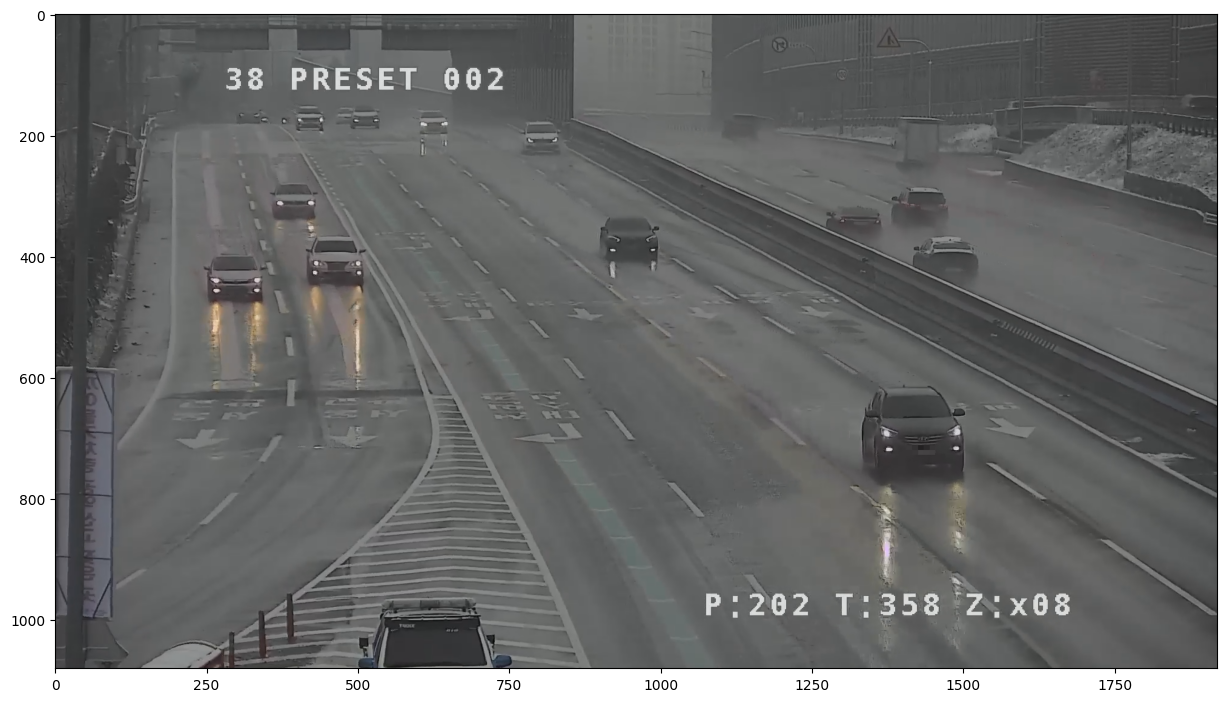

In [ ]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/drive/Othercomputers/내 노트북/google_drive/object_detection_inference/Suwon_CH02_20201213_0933_SUN_9m_NH_highway_TW5_snow_FHD_003.png'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)

load checkpoint from local path: /content/drive/Othercomputers/내 노트북/google_drive/traffic_model_result/epoch_15.pth


/usr/local/lib/python3.10/dist-packages/mmdet-2.28.2-py3.10.egg/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


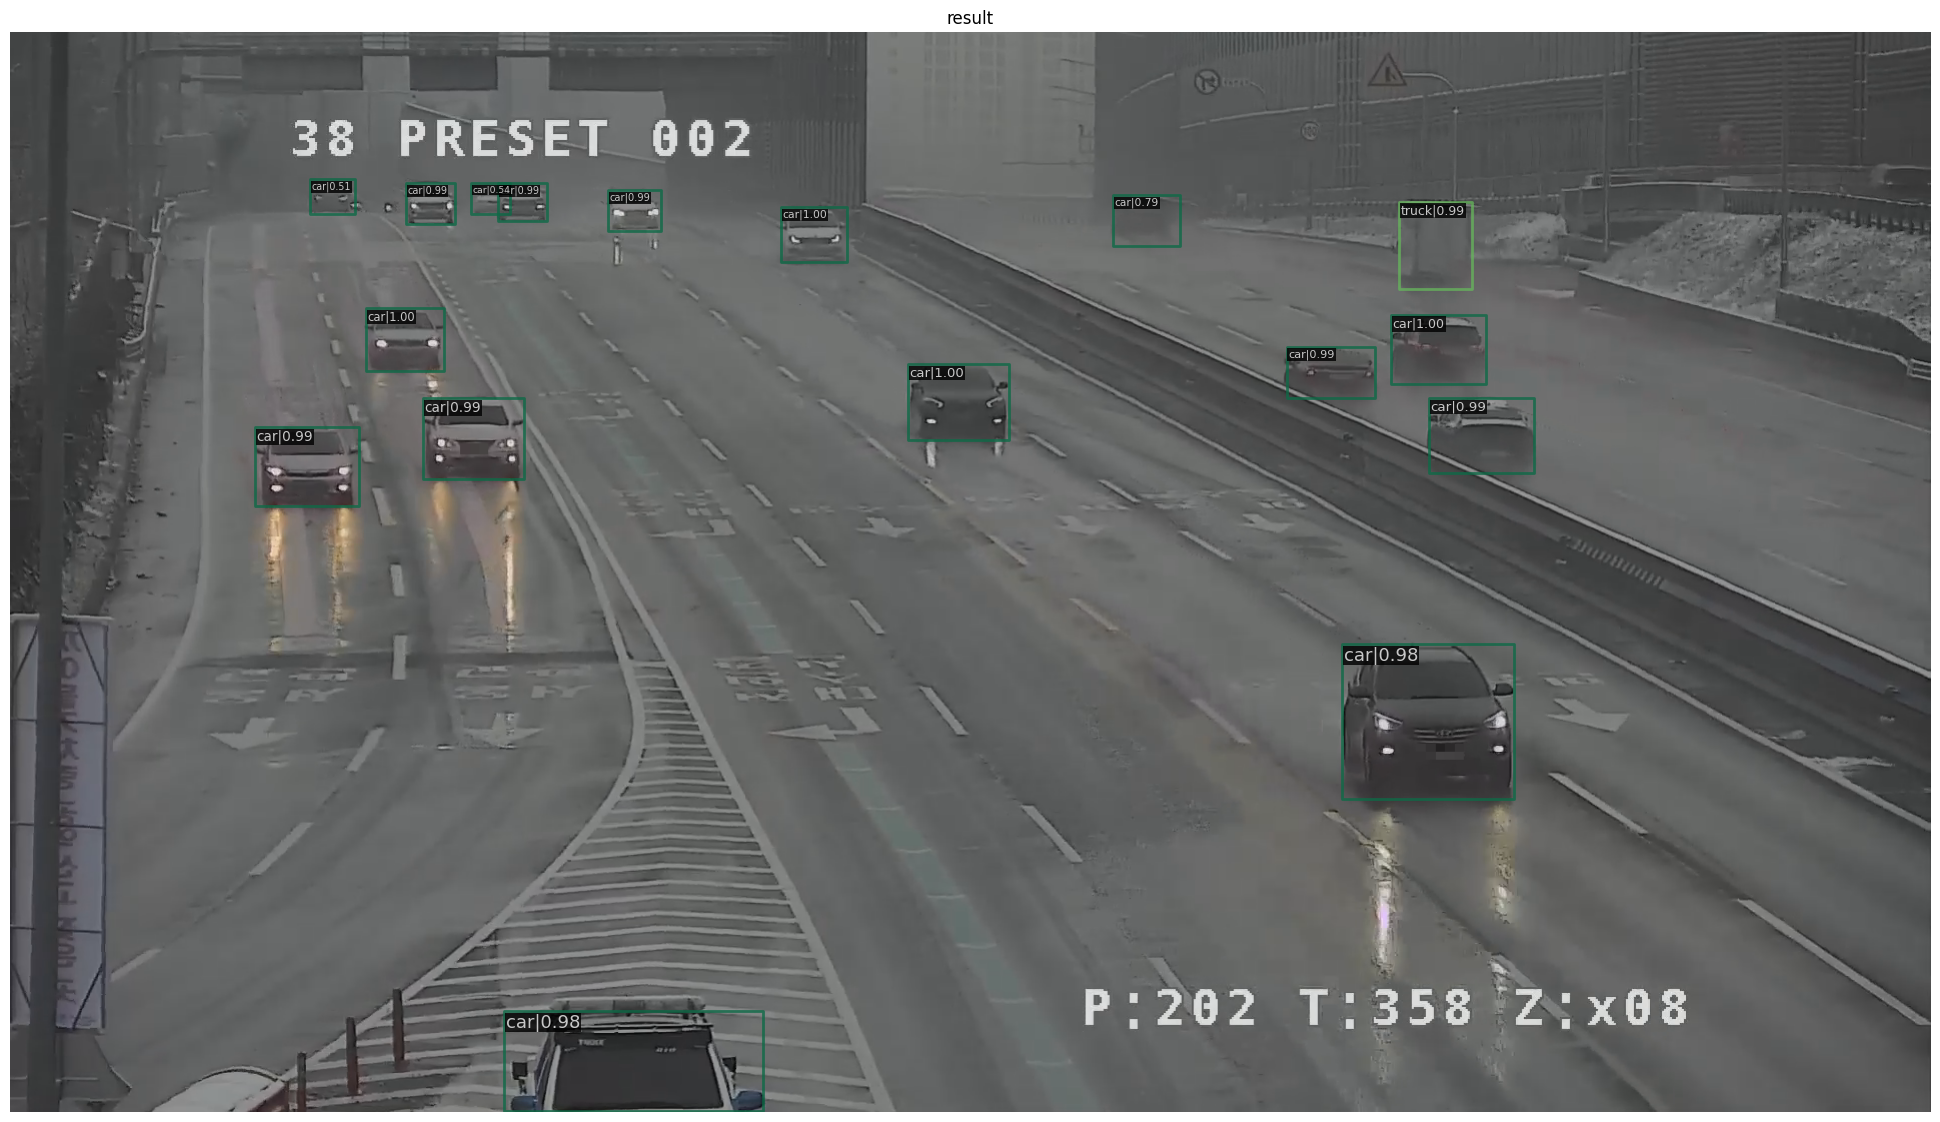

In [ ]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용
img = cv2.imread('/content/drive/Othercomputers/내 노트북/google_drive/object_detection_inference/Suwon_CH02_20201213_0933_SUN_9m_NH_highway_TW5_snow_FHD_003.png')
model = init_detector(cfg, '/content/drive/Othercomputers/내 노트북/google_drive/traffic_model_result/epoch_15.pth', device='cuda:0')

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [ ]:
# 탐지된 객체의 갯수 계산
num_objects = sum([len(bboxes) for bboxes in result if len(bboxes) > 0])

print(f"탐지된 객체의 갯수: {num_objects}")

탐지된 객체의 갯수: 17


### **Semantic Segmentation Inference**

In [ ]:
!pip install albumentations==0.4.6
!pip install segmentation-models-pytorch
!pip install torch torchvision opencv-python
!pip install segmentation-models-pytorch
!pip install torch torchvision opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65153 sha256=71985f1e835298044b04c2713d98d2d5f025e04d098abad90561fa2c80616f5d
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=3d0fa4a39ad9929dfe6d1a34a08e93931826dc4c08c45be9494469c4f8370365
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a5bc99e4c09da5d39217b3528b7d04f32d41d0307caa62b317a11122b6175604
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# train test split
from sklearn.model_selection import train_test_split

# Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import segmentation_models_pytorch as smp
from torchvision import transforms
import torch.nn.functional as F

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
image_path = '/content/drive/Othercomputers/내 노트북/google_drive/object_detection_inference/Suwon_CH02_20201213_0933_SUN_9m_NH_highway_TW5_snow_FHD_003.png'
original_mask_path = '/content/drive/Othercomputers/내 노트북/google_drive/object_detection_inference/Suwon_CH02_20201213_0933_SUN_9m_NH_highway_TW5_snow_FHD_003.png'

In [ ]:
class SingleImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        image = cv2.imread(self.image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, 0  # 더미 마스크

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

single_image_dataset = SingleImageDataset(image_path, transform=transform)
test_dataloader = torch.utils.data.DataLoader(dataset=single_image_dataset, batch_size=1, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Model/best_model.pth'

def load_model(checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model = smp.Unet(encoder_name="resnet34", encoder_weights=None, classes=5)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    return model

model = load_model(checkpoint_path, device)

def predict_single_image(dataloader, model, device):
    model.eval()
    pred_mask_test = []

    with torch.inference_mode():
        for X, _ in dataloader:
            X = X.to(device, dtype=torch.float32)
            logit_mask = model(X)
            prob_mask = F.softmax(logit_mask, dim=1)
            pred_mask = prob_mask.argmax(dim=1)
            pred_mask_test.append(pred_mask.detach().cpu())

    pred_mask_test = torch.cat(pred_mask_test)
    return pred_mask_test

pred_mask_test = predict_single_image(test_dataloader, model, device)

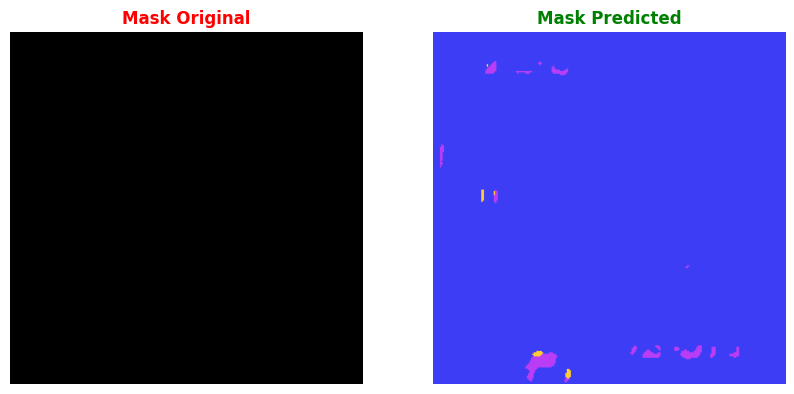

In [ ]:
def visualize_single_image_results(image_path, original_mask_path, predicted_mask, id2color):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (256, 256))

    original_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)
    original_mask = cv2.resize(original_mask, (256, 256))

    predicted_mask = predicted_mask.squeeze().numpy()

    mask_zeros_pred = np.zeros((256, 256, 3), dtype=np.uint8)
    mask_zeros_orig = np.zeros((256, 256, 3), dtype=np.uint8)

    for h in range(256):
        for w in range(256):
            pred_idcolor = int(predicted_mask[h, w])
            orig_idcolor = int(original_mask[h, w])

            if pred_idcolor in id2color:
                mask_zeros_pred[h, w, :] = id2color[pred_idcolor]
            if orig_idcolor in id2color:
                mask_zeros_orig[h, w, :] = id2color[orig_idcolor]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax[0].imshow(mask_zeros_orig)
    ax[0].set_title("Mask Original", fontsize=12, fontweight="bold", color="red")
    ax[0].axis('off')

    ax[1].imshow(mask_zeros_pred)
    ax[1].set_title("Mask Predicted", fontsize=12, fontweight="bold", color="green")
    ax[1].axis('off')

    plt.show()

    return mask_zeros_pred

id2color = {
    0: (184, 61, 245),  # background
    1: (255, 53, 94),   # road_sign
    2: (255, 204, 51),  # car
    3: (221, 255, 51),  # marking
    4: (61, 61, 245)    # road_surface
}

mask_zeros_pred = visualize_single_image_results(image_path, original_mask_path, pred_mask_test, id2color)

In [ ]:
# 색상 정의
marking_color = (221, 255, 51)  # #ddff33
road_surface_color = (61, 61, 245)  # #3d3df5

# 색상별 픽셀 수 계산 함수
def count_pixels(image, color):
    return np.sum(np.all(image == color, axis=-1))

# 픽셀 수 계산
marking_count = count_pixels(mask_zeros_pred, marking_color)
road_surface_count = count_pixels(mask_zeros_pred, road_surface_color)

print(f"Marking (color {marking_color}) pixels count: {marking_count}")
print(f"Road Surface (color {road_surface_color}) pixels count: {road_surface_count}")

total_pixel_count = marking_count + road_surface_count

print(total_pixel_count)

Marking (color (221, 255, 51)) pixels count: 0
Road Surface (color (61, 61, 245)) pixels count: 64840
64840


In [59]:
# 교통 혼잡 지수(TCI) 계산 (TCI = N / A) (N = 도로구간의 차량 개수, A = 도로 구간의 면적)
# 원활한 상태 (Free Flow) => TCI < 0.10
# 적정 상태 (Stable Flow) => 0.01 <= TCI < 0.25
# 혼잡 상태 (Congestion Flow) => 0.25 <= TCI < 0.50
# 심각한 혼잡 상태 (Heavy Congestion) TCI >= 0.50

traffic_congestion_index = num_objects / total_pixel_count

print(traffic_congestion_index)

0.0002621838371375694


### **단일 Image Final Inference**

In [58]:
import pickle

with open('reconstruction_error_data.pkl', 'rb') as f:
    reconstruction_error_data = pickle.load(f)

print(reconstruction_error_data['reconstruction_error_data'])

reconstruction_error_data = reconstruction_error_data['reconstruction_error_data']

0.00092263607


In [ ]:
# config 파일은 faster rcnn resnet 50 backbone 사용.
# 학습으로 생성된 모델을 Google Drive에 저장

config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/drive/Othercomputers/내 노트북/google_drive/traffic_model_result/epoch_15.pth'

In [ ]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg)
# print(cfg.pretty_text)

Config (path: /content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py): {'model': {'type': 'FasterRCNN', 'backbone': {'type': 'ResNet', 'depth': 50, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'frozen_stages': 1, 'norm_cfg': {'type': 'BN', 'requires_grad': True}, 'norm_eval': True, 'style': 'pytorch', 'init_cfg': {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}}, 'neck': {'type': 'FPN', 'in_channels': [256, 512, 1024, 2048], 'out_channels': 256, 'num_outs': 5}, 'rpn_head': {'type': 'RPNHead', 'in_channels': 256, 'feat_channels': 256, 'anchor_generator': {'type': 'AnchorGenerator', 'scales': [8], 'ratios': [0.5, 1.0, 2.0], 'strides': [4, 8, 16, 32, 64]}, 'bbox_coder': {'type': 'DeltaXYWHBBoxCoder', 'target_means': [0.0, 0.0, 0.0, 0.0], 'target_stds': [1.0, 1.0, 1.0, 1.0]}, 'loss_cls': {'type': 'CrossEntropyLoss', 'use_sigmoid': True, 'loss_weight': 1.0}, 'loss_bbox': {'type': 'L1Loss', 'loss_weight': 1.0}}, 'roi_head': {'type': 'StandardRoIHead', 'bbox_ro

In [ ]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정.
cfg.dataset_type = 'TrafficDataset'
cfg.data_root = '/content/datasets/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'TrafficDataset'
cfg.data.train.data_root = '/content/datasets/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'train/images'

cfg.data.val.type = 'TrafficDataset'
cfg.data.val.data_root = '/content/datasets/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'validation/images'

cfg.data.test.type = 'TrafficDataset'
cfg.data.test.data_root = '/content/datasets/'
cfg.data.test.ann_file = 'test.txt'
cfg.data.test.img_prefix = 'train/images'

# class의 갯수 수정.
cfg.model.roi_head.bbox_head.num_classes = 3
# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리로 구글 Drive 설정.
cfg.work_dir = '/content/drive/Othercomputers/내 노트북/google_drive/traffic_model_result'

# 학습율 변경 환경 파라미터 설정.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None # 지우기?
# 20번 마다 한번씩 로그를 작성(학습시 cell에 출력 됨, None.log.json에도 저장됨)
cfg.log_config.interval = 20 # 10

cfg.runner.max_epochs = 15

# 평가 metric 설정.
cfg.evaluation.metric = 'mAP'
# 평가 metric 수행할 epoch interval 설정.
cfg.evaluation.interval = 1
# 학습 iteration시마다 모델을 저장할 epoch interval 설정.
cfg.checkpoint_config.interval = 1 # 2

# 학습 시 Batch size 설정(단일 GPU 별 Batch size로 설정됨) (gpu가 2개이면 batch size가 8이 된다.)
cfg.data.samples_per_gpu = 5 # 한번의 에포크당 약 1975개의 데이터셋을 학습한다.

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정.
cfg.lr_config.policy='step'

# ConfigDict' object has no attribute 'device 오류 발생시 반드시 설정 필요. https://github.com/open-mmlab/mmdetection/issues/7901
cfg.device='cuda'

# We can initialize the logger for training and have a look
# at the final config used for training
# print(f'Config:\n{cfg.pretty_text}')

load checkpoint from local path: /content/drive/Othercomputers/내 노트북/google_drive/traffic_model_result/epoch_15.pth
Image size: 1920 x 1080


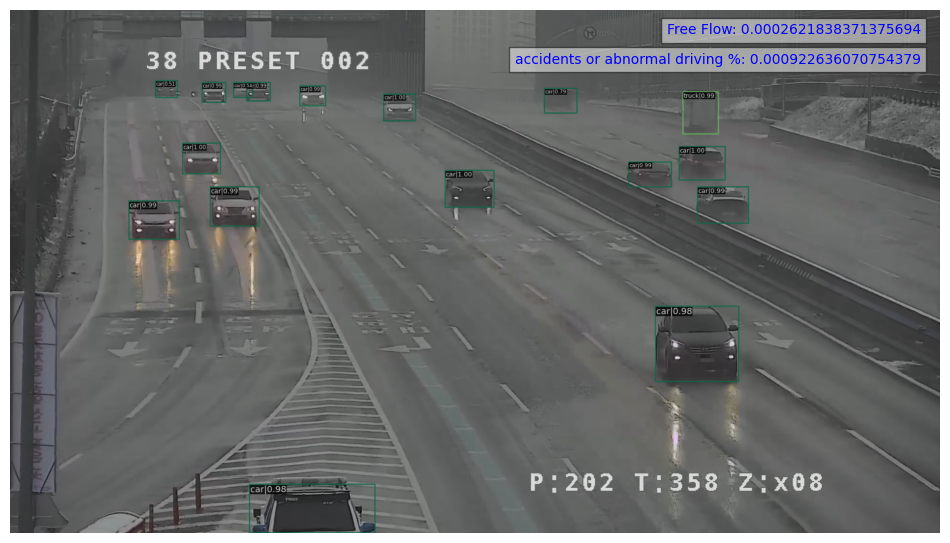

In [74]:
import cv2
import matplotlib.pyplot as plt
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
import mmcv

# 이미지 경로와 모델 초기화
img_path = '/content/drive/Othercomputers/내 노트북/google_drive/object_detection_inference/Suwon_CH02_20201213_0933_SUN_9m_NH_highway_TW5_snow_FHD_003.png'
checkpoint_path = '/content/drive/Othercomputers/내 노트북/google_drive/traffic_model_result/epoch_15.pth'
model = init_detector(cfg, checkpoint_path, device='cuda:0')

# BGR Image 사용
img = cv2.imread(img_path)

# 객체 탐지
result = inference_detector(model, img)

# show_result_pyplot을 사용하여 결과를 표시하고 이미지 저장
output_image_path = '/content/drive/Othercomputers/내 노트북/google_drive/object_detection_inference/output_image.png'
show_result_pyplot(model, img, result, score_thr=0.3, out_file=output_image_path)

# 저장된 이미지를 불러옴
img_with_boxes = cv2.imread(output_image_path)

# 이미지 크기 확인 (해상도 유지)
height, width, _ = img_with_boxes.shape
print(f"Image size: {width} x {height}")

# 텍스트 추가
if traffic_congestion_index < 0.1:
    traffic_congestion_result = "Free Flow: " + str(traffic_congestion_index)
elif 0.1 <= traffic_congestion_index < 0.25:
    traffic_congestion_result = "Stable Flow: " + str(traffic_congestion_index)
elif 0.25 <= traffic_congestion_index < 0.5:
    traffic_congestion_result = "Congestion Flow: " + str(traffic_congestion_index)
else:
    traffic_congestion_result = "Heavy Congestion Flow: " + str(traffic_congestion_index)

anomaly_detection_result = f'accidents or abnormal driving %: {reconstruction_error_data}'

# 이미지를 RGB로 변환하여 Matplotlib로 표시
img_with_boxes_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))  # 그림의 크기를 설정하여 해상도 유지
plt.imshow(img_with_boxes_rgb)
plt.axis('off')

# 텍스트 추가
plt.text(img_with_boxes_rgb.shape[1] - 40, 50, traffic_congestion_result, bbox=dict(facecolor='white', alpha=0.5),
         fontsize=10, color='blue', ha='right')
plt.text(img_with_boxes_rgb.shape[1] - 40, 110, anomaly_detection_result, bbox=dict(facecolor='white', alpha=0.5),
         fontsize=10, color='blue', ha='right')

# 결과 이미지 출력
plt.show()
